In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from datetime import datetime
import math
from matplotlib.colors import ListedColormap
ann_file = 'annotations.json'
coco = COCO(ann_file)


loading annotations into memory...
Done (t=2.99s)
creating index...
index created!


# Preprocess Dataset

In [2]:
CMAP = ListedColormap(["purple", "blue", "green", "yellow"])

def printst(*args, **kargs):
    # return
    print(*args, **kargs)
class SeaTurtleDataset(tf.keras.utils.Sequence):
    def __init__(self, img_dir, batch_size, split_date, img_size=(128, 128), shuffle=True, split='train'):
        self.img_dir = img_dir
        self.coco = coco
        self.split_date = datetime.strptime(split_date, '%Y:%m:%d')
        self.img_ids = [
            img_id for img_id, img_info in self.coco.imgs.items()
            if self._is_in_split(img_info.get('timestamp', '1970:01:01 00:00:00'), split)
        ]
        #--------
        self.img_ids= self.img_ids[:len(self.img_ids)]
        #--------
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.info = {'nonAnns':0}
        print(f"Dataset initialized with {len(self.img_ids)} images for split '{split}'")

    def _is_in_split(self, timestamp_str, split):
        img_datetime = self._clean_and_parse_timestamp(timestamp_str)
        return img_datetime < self.split_date if split == 'train' else img_datetime >= self.split_date

    def _clean_and_parse_timestamp(self, timestamp_str):
        try:
            return datetime.strptime(timestamp_str[:10], '%Y:%m:%d')
        except ValueError:
            return datetime(1970, 1, 1)

    def __len__(self):
        return len(self.img_ids) // self.batch_size

    def __getitem__(self, index):
        batch_ids = self.img_ids[index * self.batch_size:(index + 1) * self.batch_size]
        # print(batch_ids)
        images, masks = [], []
        temp = 0
        maskInfo = {}
        for img_id in batch_ids:
            # maskInfo[img_id]={0:0, 1:0, 2:0}
            img_info = self.coco.loadImgs(img_id)[0]
            img_path = os.path.join(self.img_dir, img_info['file_name'])
            
            image = cv2.resize(np.array(Image.open(img_path)), self.img_size) / 255.0
            image = np.expand_dims(image, axis=-1) if image.ndim == 2 else image  # handle grayscale images

            
            anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
            
            if not anns:  # anns not exist
                mask = np.zeros(self.img_size, dtype=np.uint8)
                self.info['nonAnns'] += 1
            else:
                mask = cv2.resize(self.coco.annToMask(anns[0]), self.img_size)
                # print(anns[0]['category_id'])
                cat_ids = self.coco.getCatIds()
                anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None))
                for ann in anns:
                    # method one
                    # ann_mask = self.coco.annToMask(ann)  # ndim = 2
                    # # order=0: nearest-neighbor interpolation
                    # ann_mask_resized = cv2.resize(ann_mask, self.img_size, interpolation=cv2.INTER_NEAREST)
                    # mask[ann_mask_resized==1] = ann['category_id']

                    # method two
                    """
                    {'id': 1, 'name': 'turtle', 'supercategory': ''}
                    {'id': 2, 'name': 'flipper', 'supercategory': ''}
                    {'id': 3, 'name': 'head', 'supercategory': ''}
                    """
                    ann_mask = cv2.resize(self.coco.annToMask(ann), self.img_size)
                    if ann['category_id'] != 1:
                        mask[ann_mask==1] = ann['category_id']
                    else:
                        mask[(ann_mask==1)&(mask==0)] = ann['category_id']

                # if np.any(mask==4):  # resulted by resize img
                #     mask[mask==4] = 3

            # plt.imshow(mask)
            
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        images_array = np.array(images)
        masks_array = np.array(masks).astype(np.int32)
        return images_array, masks_array

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.img_ids)



img_dir = ''
batch_size = 4
# wm = hm = 0
# for img_id, img_info in coco.imgs.items():
#     width = img_info['width']
#     height = img_info['height']
#     # if img_info['width'] not in [i for i in range(1000, 2001)] or img_info['height'] not in [i for i in range(1000, 2001)]:
#     if wm<width:
#         wm = width
#     if hm < height:
#         hm = height

# print(wm, hm)  2000, 2000
img_size = (128, 128)  # max width = max height = 2000, to avoid resize remove value 1
split_date = '2021:01:01'  # Split date for training and validation

# Load training and validation datasets
train_dataset = SeaTurtleDataset(img_dir=img_dir, batch_size=batch_size, img_size=img_size, split='train', split_date=split_date)
val_dataset = SeaTurtleDataset(img_dir=img_dir, batch_size=batch_size, img_size=img_size, split='validation', split_date=split_date)


Dataset initialized with 7502 images for split 'train'
Dataset initialized with 1227 images for split 'validation'


# Build Model, train Model

Epoch 1/20
1875/1875 [==============================] - 1163s 619ms/step - loss: 0.2406 - accuracy: 0.8845 - val_loss: 0.1839 - val_accuracy: 0.8573
Epoch 2/20
1875/1875 [==============================] - 1141s 609ms/step - loss: 0.1429 - accuracy: 0.8698 - val_loss: 0.1208 - val_accuracy: 0.8700
Epoch 3/20
1875/1875 [==============================] - 1126s 600ms/step - loss: 0.1073 - accuracy: 0.8663 - val_loss: 0.1231 - val_accuracy: 0.8567
Epoch 4/20
1875/1875 [==============================] - 1133s 604ms/step - loss: 0.0909 - accuracy: 0.8651 - val_loss: 0.1133 - val_accuracy: 0.8593
Epoch 5/20
1875/1875 [==============================] - 1138s 607ms/step - loss: 0.0779 - accuracy: 0.8640 - val_loss: 0.0880 - val_accuracy: 0.8591
Epoch 6/20
1875/1875 [==============================] - 1140s 608ms/step - loss: 0.0700 - accuracy: 0.8634 - val_loss: 0.0993 - val_accuracy: 0.8759
Epoch 7/20
1875/1875 [==============================] - 1141s 609ms/step - loss: 0.0639 - accuracy: 0.8628

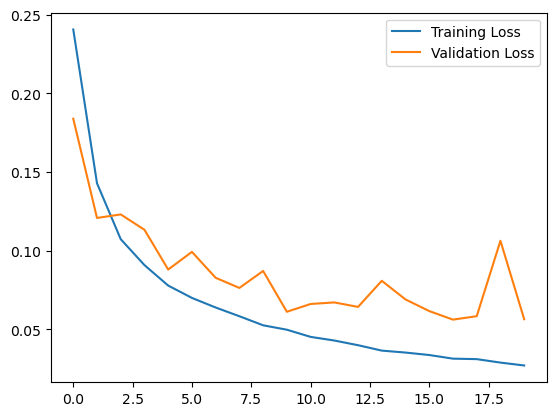

In [3]:
# Convolution block
def conv_block(input, num_filters):
	#  the network will auto create kernel 3*3*n, where n is the channel of inputs
	c = layers.Conv2D(num_filters, (3, 3), padding='same')(input)
	c = layers.BatchNormalization()(c)
	c = layers.Activation("relu")(c)

	c = layers.Conv2D(num_filters, (3, 3), padding='same')(c)
	c = layers.BatchNormalization()(c)
	c = layers.Activation("relu")(c)
	
	return c

def encoder_block(inputs, num_filters):
	c = conv_block(inputs, num_filters)
	p = layers.MaxPooling2D((2, 2))(c)

	return c, p

def decoder_block(inputs, skip_features, num_filters):
	ct = layers.Conv2DTranspose(num_filters, (2,2), strides=(2,2), padding='same')(inputs)
	ct = layers.Concatenate()([ct, skip_features])
	c = conv_block(ct, num_filters)
	return c	


# Define the U-Net model
# Define the U-Net model
def unet_model(input_size=(128, 128, 3), num_classes=4):
    inputs = layers.Input(input_size)
        
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)

    bottom_c = conv_block(p2, 256)

    d_c2 = decoder_block(bottom_c, c2, 128)
    d_c1 = decoder_block(d_c2, c1, 64)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(d_c1)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize and compile the model
model = unet_model(input_size=(*img_size, 3), num_classes=4)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)



# Plot training history for analysis
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()




# Prediction

1/1 [==============================] - 0s 300ms/step
True
Image shape: (4, 128, 128, 3), Mask shape: (4, 128, 128, 1), Prediction shape: (4, 128, 128)


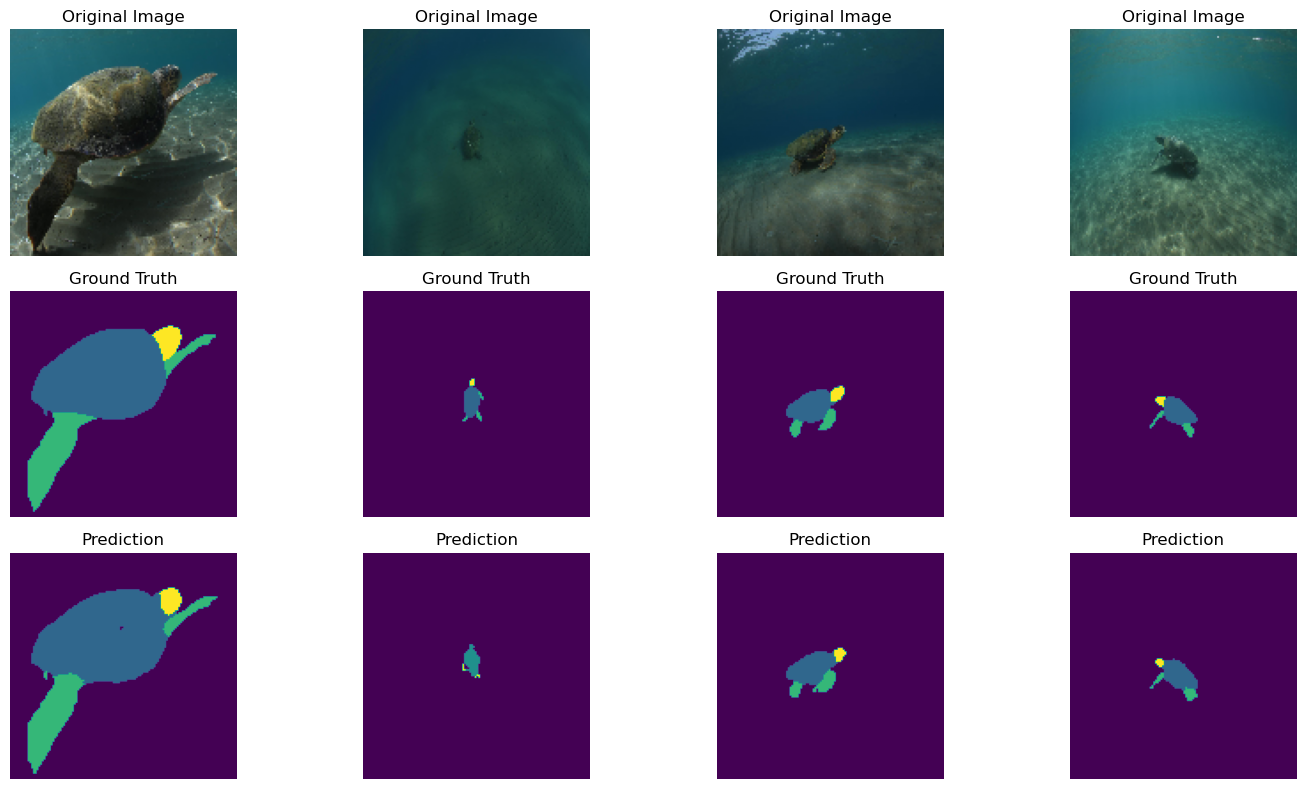

In [ ]:

# Get a batch of images and masks from the dataset
images, masks = val_dataset[0]

# Generate predictions for the images
result = model.predict(images)

# type(result)  # type(result)
# result.shape  # (4, 128, 128, 4)
print(np.any(result>0.4))
# result


predictions = np.argmax(result, axis=-1)

# type(predictions)  # numpy.ndarray
# predictions.shape  # (4, 128, 128)
np.any(predictions>0)

# Ensure predictions have the correct shape
print(f"Image shape: {images.shape}, Mask shape: {masks.shape}, Prediction shape: {predictions.shape}")



plt.figure(figsize=(15, 8))
for i in range(len(images)):
    # Display the original image
    plt.subplot(3, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Original Image")
    
    # Display the ground truth mask with a colormap
    plt.subplot(3, len(images), i + 1 + len(images))
    plt.imshow(masks[i].squeeze())
    plt.axis('off')
    plt.title("Ground Truth")
    
    # Display the prediction mask with a colormap
    plt.subplot(3, len(images), i + 1 + 2 * len(images))
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title("Prediction")

plt.tight_layout()
plt.show()

Save and reload model

In [7]:
model.save('UnetModel')

INFO:tensorflow:Assets written to: UnetModel\assets


INFO:tensorflow:Assets written to: UnetModel\assets


In [ ]:
model1 = load_model("UnetModel")

Test Reloaded Model

1/1 [==============================] - 0s 152ms/step
True
Image shape: (4, 128, 128, 3), Mask shape: (4, 128, 128, 1), Prediction shape: (4, 128, 128)


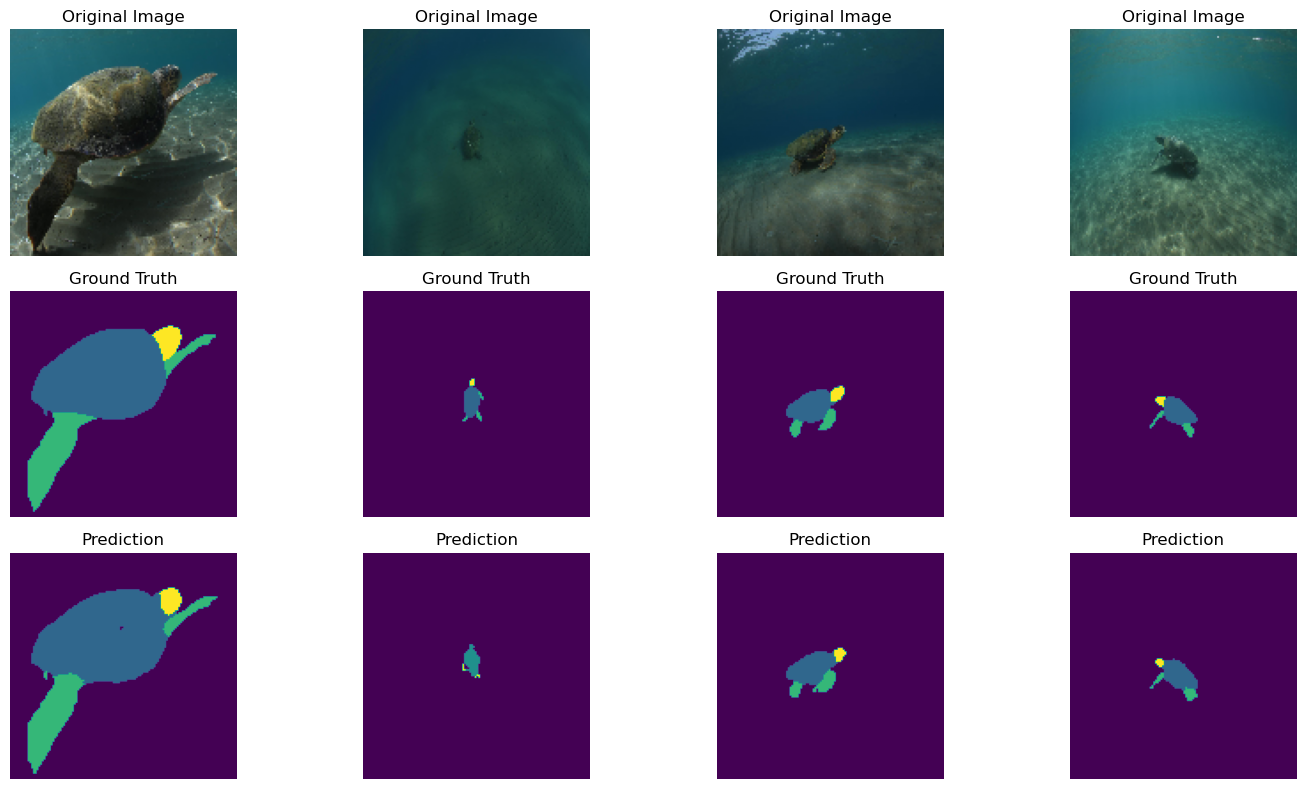

In [11]:
result = model1.predict(images)

# type(result)  # type(result)
# result.shape  # (4, 128, 128, 4)
print(np.any(result>0.4))
# result


predictions = np.argmax(result, axis=-1)

# type(predictions)  # numpy.ndarray
# predictions.shape  # (4, 128, 128)
np.any(predictions>0)

# Ensure predictions have the correct shape
print(f"Image shape: {images.shape}, Mask shape: {masks.shape}, Prediction shape: {predictions.shape}")



plt.figure(figsize=(15, 8))
for i in range(len(images)):
    # Display the original image
    plt.subplot(3, len(images), i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title("Original Image")
    
    # Display the ground truth mask with a colormap
    plt.subplot(3, len(images), i + 1 + len(images))
    plt.imshow(masks[i].squeeze())
    plt.axis('off')
    plt.title("Ground Truth")
    
    # Display the prediction mask with a colormap
    plt.subplot(3, len(images), i + 1 + 2 * len(images))
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title("Prediction")

plt.tight_layout()
plt.show()

